# Introduction

This file is meant for an initial exploration of CitiBike data from 2023. In this file, I have visualized features provided by CitiBike themselves and also engineering temporal and geographical features that I considered important for future analysis. 

## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import holidays
import seaborn as sns

## Importing data

In [2]:
df23 = pd.read_csv("data/2023.csv", on_bad_lines="skip")

/var/folders/3r/5kfvm8sd25v522wh526y75lw0000gn/T/ipykernel_71298/1537279215.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df23 = pd.read_csv("data/2023.csv", on_bad_lines="skip")


In [3]:
df23.shape

(35107030, 13)

In [4]:
df23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35107030 entries, 0 to 35107029
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 3.4+ GB


In [5]:
df23.describe()

,start_lat,start_lng,end_lat,end_lng
count,3.510703e+07,3.510703e+07,3.508076e+07,3.508076e+07
mean,4.073982e+01,-7.397278e+01,4.073966e+01,-7.397283e+01
std,4.062097e-02,2.783025e-02,4.790481e-02,5.115839e-02
min,4.057483e+01,-7.407222e+01,-3.726000e+01,-1.733700e+02
25%,4.071485e+01,-7.399256e+01,4.071485e+01,-7.399266e+01
50%,4.073902e+01,-7.398020e+01,4.073827e+01,-7.398017e+01
75%,4.076311e+01,-7.395608e+01,4.076270e+01,-7.395608e+01
max,4.089416e+01,-7.379639e+01,4.117000e+01,0.000000e+00


First, we'll drop the index column, ride_id, start_station_name, end_station_name to make working with the dataset easier due to the size

In [6]:
df23.drop(["ride_id", "start_station_name", "end_station_name", "start_station_id", "end_station_id"], axis = 1, inplace = True)

Now, we will convert certain columns into more relevant datatypes to reduce the memory occupied

In [7]:
df23['rideable_type'] = df23['rideable_type'].astype('category')

df23['started_at'] = pd.to_datetime(df23['started_at'], errors='coerce')
df23['ended_at'] = pd.to_datetime(df23['ended_at'], errors='coerce')

df23['member_casual'] = df23['member_casual'].astype('category')

In [8]:
df23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35107030 entries, 0 to 35107029
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   rideable_type  category      
 1   started_at     datetime64[ns]
 2   ended_at       datetime64[ns]
 3   start_lat      float64       
 4   start_lng      float64       
 5   end_lat        float64       
 6   end_lng        float64       
 7   member_casual  category      
dtypes: category(2), datetime64[ns](2), float64(4)
memory usage: 1.6 GB


# Data Cleaning

### Let us ensure the data we possess is stricly from 2024

In [9]:
df23 = df23[(df23["started_at"] >= '2023-01-01') & (df23['started_at'] <= '2023-12-31')]

In [10]:
print(df23['started_at'].min())

print(df23['ended_at'].max())

2023-01-01 00:00:13.021000
2023-12-31 23:56:33.600000


### Handling Null rows

In [11]:
df23.isnull().sum()

rideable_type        0
started_at           0
ended_at             0
start_lat            0
start_lng            0
end_lat          26180
end_lng          26180
member_casual        0
dtype: int64

As we can observe, we have around 95k rides where we dont have ending station information, and 62k rides where we do not have ending position
For future analyis, we want rides where we possess ending and starting positions, as well as station ids. Hence we will drop the null rows, since we have 27 million rides, this will not have a significant impact on our analysis

In [12]:
df23.dropna(inplace = True)

### Handling rows where the ride ends before it begins, or is extremely long

In [13]:
df23["duration_minutes"] = (df23["ended_at"] - df23["started_at"]).dt.total_seconds() / 60

df23 = df23[(df23["duration_minutes"] > 0) & (df23["duration_minutes"] <= 360)]

## Basic Visualizations

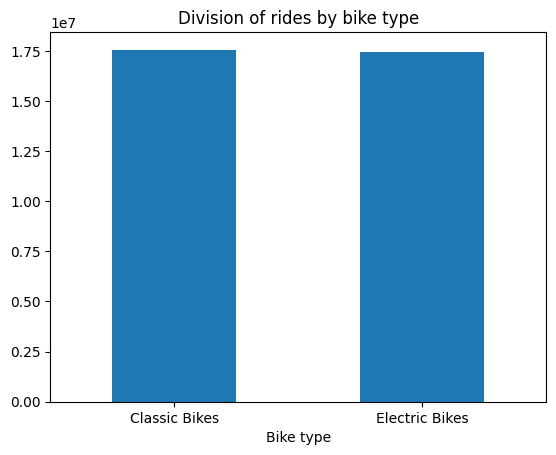

In [14]:
df23['rideable_type'].value_counts().plot(kind = "bar")
plt.title("Division of rides by bike type")
plt.xlabel("Bike type")
plt.xticks(ticks = range(2), labels = ["Classic Bikes", "Electric Bikes"], rotation = 0)
plt.show()

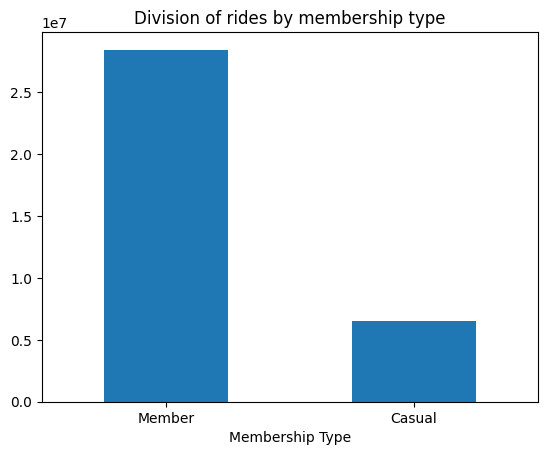

In [15]:
df23['member_casual'].value_counts().plot(kind = "bar")
plt.title("Division of rides by membership type")
plt.xlabel("Membership Type")
plt.xticks(ticks = range(2), labels = ["Member", "Casual"], rotation = 0)
plt.show()

/Users/dhruv/Desktop/CitiBike/.venv/lib/python3.12/site-packages/seaborn/distributions.py:474: RuntimeWarning: invalid value encountered in subtract
  edges = res[orient].to_numpy() - widths / 2


Text(0.5, 0, 'Duration in minutes')

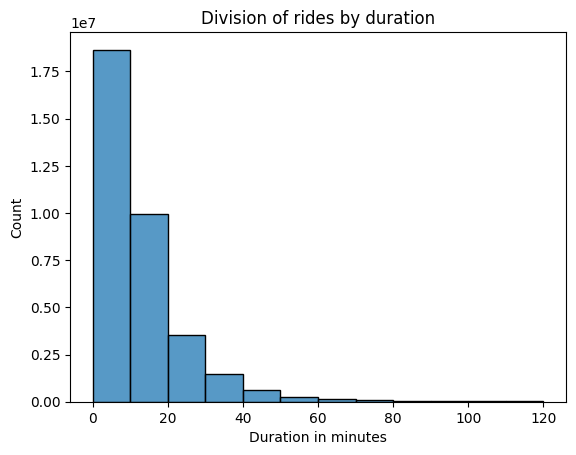

In [16]:
sns.histplot(data = df23, x = "duration_minutes", bins = [0,10,20,30,40,50,60,70,80,90,100,110,120,float('inf')])
plt.title("Division of rides by duration")
plt.xlabel("Duration in minutes")

In [17]:
df23['duration_minutes'].max()

np.float64(359.99711666666667)

# Engineering Temporal Features

In [18]:
df23["date"] = pd.to_datetime(df23["started_at"].dt.date)
df23["hour"] = df23["started_at"].dt.hour.astype("category")
df23['weekday'] = df23['started_at'].dt.day_name().astype("category")
holidays_US = holidays.US()
df23["is_holiday"] = df23['date'].apply(lambda x: x in holidays_US)

We engineering 3 temporal features: Date, Hour of the day and Day of the week

Let us visualize the data as per these features

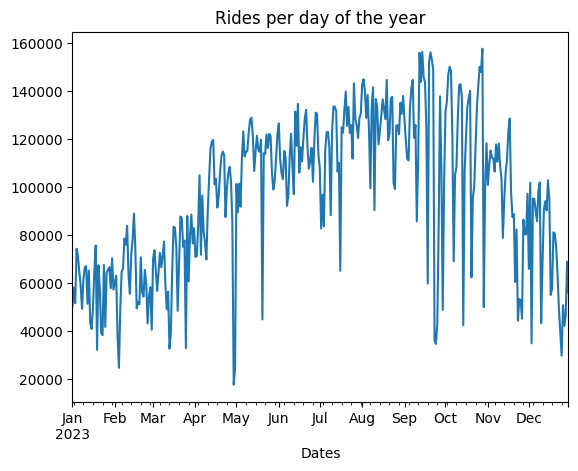

In [19]:
df23.groupby("date").size().sort_index().plot(kind = "line")
plt.title("Rides per day of the year")
plt.xlabel("Dates")
plt.show()

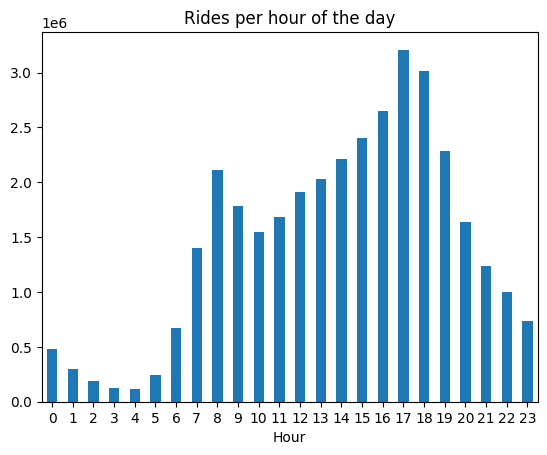

In [20]:
df23["hour"].value_counts().sort_index().plot(kind = "bar")
plt.title("Rides per hour of the day")
plt.xlabel("Hour")
plt.xticks(rotation = 0)
plt.show()

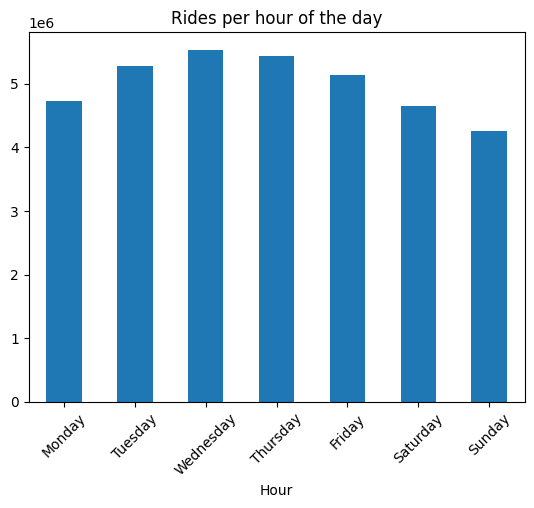

In [21]:
df23["weekday"].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind = "bar")
plt.title("Rides per hour of the day")
plt.xlabel("Hour")
plt.xticks(rotation = 45)
plt.show()

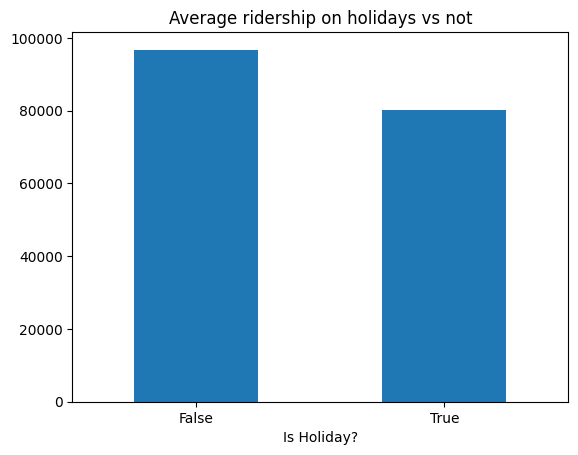

In [22]:
daily_rides = df23.groupby(['date', 'is_holiday']).size().reset_index(name='ride_count')
avg_rides = daily_rides.groupby('is_holiday')['ride_count'].mean().plot(kind = "bar")
plt.title("Average ridership on holidays vs not")
plt.xlabel("Is Holiday?")
plt.xticks(rotation = 0)
plt.show()

# Engineering Physical Features

In [23]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df23['distance_km'] = haversine_distance(df23['start_lat'], df23['start_lng'], df23['end_lat'], df23['end_lng'])

In [24]:
df23['start_lat'] = df23['start_lat'].round(4)
df23['start_lng'] = df23['start_lng'].round(4)
df23['end_lat']   = df23['end_lat'].round(4)
df23['end_lng']   = df23['end_lng'].round(4)

df23['start_point'] = list(zip(df23['start_lng'], df23['start_lat']))
df23['end_point'] = list(zip(df23['end_lng'], df23['end_lat']))

df23.drop(["start_lng", "start_lat", "end_lng", "end_lat"], axis = 1, inplace = True)

In [25]:
from shapely.geometry import Point
import geopandas as gpd

# Load boroughs with only necessary columns
boroughs = gpd.read_file("data/boroughs.geojson")[['geometry', 'boroname']]

# Convert start_point tuples to shapely Points
geometry = [Point(xy) for xy in df23['start_point']]
geo_df = gpd.GeoDataFrame(df23, geometry=geometry, crs="EPSG:4326")

# Spatial join to get boroughs
geo_df = gpd.sjoin(geo_df, boroughs, how='left', predicate='within')

# Rename and save
geo_df.rename(columns={'boroname': 'start_borough'}, inplace=True)
df23 = geo_df

df23['start_borough'] = df23['start_borough'].astype("category")
df23.drop(['geometry', 'index_right'], axis = 1, inplace = True)

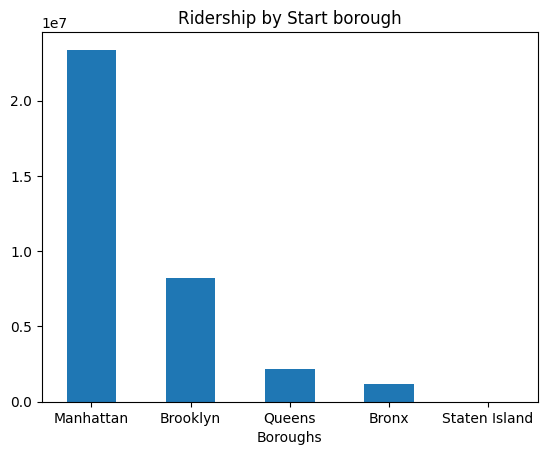

In [26]:
df23['start_borough'].value_counts().plot(kind = "bar")
plt.title("Ridership by Start borough")
plt.xlabel("Boroughs")
plt.xticks(rotation = 0)
plt.show()

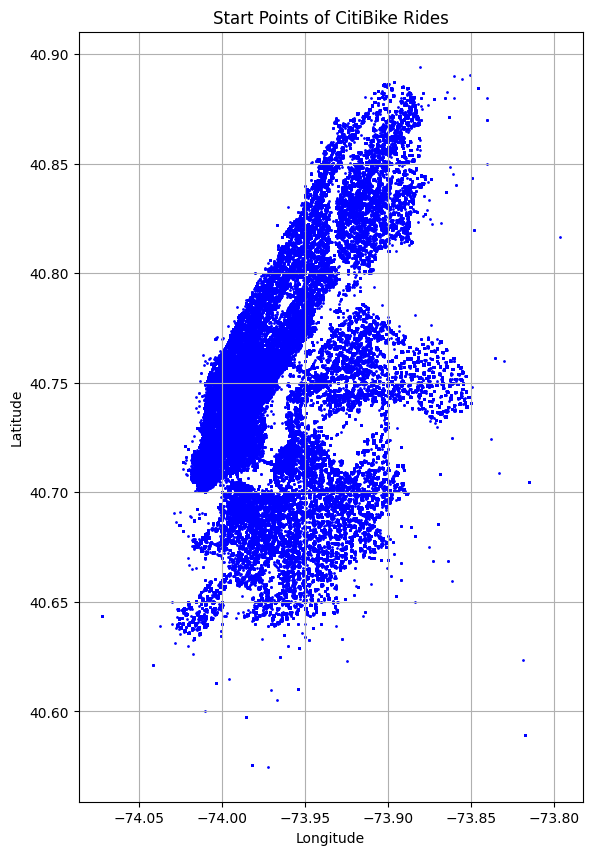

In [27]:
geometry = [Point(lng, lat) for lng, lat in df23['start_point']]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df23.copy(), geometry=geometry)

# Set the coordinate reference system (WGS 84)
gdf.set_crs(epsg=4326, inplace=True)

# Plot the start points
gdf.plot(markersize=1, color='blue', figsize=(10, 10))
plt.title("Start Points of CitiBike Rides")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [28]:
df23.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34994468 entries, 0 to 35107029
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   rideable_type     category      
 1   started_at        datetime64[ns]
 2   ended_at          datetime64[ns]
 3   member_casual     category      
 4   duration_minutes  float64       
 5   date              datetime64[ns]
 6   hour              category      
 7   weekday           category      
 8   is_holiday        bool          
 9   distance_km       float64       
 10  start_point       object        
 11  end_point         object        
 12  start_borough     category      
dtypes: bool(1), category(5), datetime64[ns](3), float64(2), object(2)
memory usage: 2.3+ GB


In [29]:
df23.to_parquet("2023.parquet", engine = "pyarrow")